Last version of images: 5 years LSST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import galsim
import scipy.stats as stats
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import scipy

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils, plot, generator, results_processing, boxplot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_alpha, denorm, delta_min, norm, load_vae_full
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, plot_rgb, createCircularMask, mean_var, plot_corner_latent, scatter_galaxies
from tools_for_VAE.results_processing import processing
from tools_for_VAE.boxplot import boxplot_func

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Function to import deblender

In [3]:
deblender_lsst,deblender_utils_lsst, encoder_lsst, decoder_lsst, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v10/mse/', #7/bis
                                                                                     6, folder = True)#6/train_6  #7 (PReLu pas sur echantillons 28)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
deblender_lsst_euclid,deblender_utils_lsst_euclid, encoder_lsst_euclid, decoder_lsst_euclid, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST_EUCLID/deblender/v10/mse/',#6/bis_bis
                                                                                            10, folder = True)#5/train_7  #6 (PReLu pas sur echantillons 28)

# Fix parameters

In [5]:
# Batch size for training
batch_size = 100

# Physical stamp size
phys_stamp_size_euclid = 6.4 # arcsec for VIS Euclid instrument
phys_stamp_size_lsst = 3.2 # arcsec for LSST instrument

# Pixel scales
pixel_scale_euclid_vis = 0.1 # arcsec/pixel
pixel_scale_lsst = 0.2

# Stamp size used
stamp_size = int(phys_stamp_size_euclid/pixel_scale_euclid_vis)

# Load test data

Load shifts and images

In [6]:
data_dir = '/sps/lsst/users/barcelin/data/blended_galaxies/centered/test/'
root = 'galaxies_blended_20191024'

In [7]:
shifts = np.load(os.path.join(data_dir, root+'_0_shifts.npy'))

In [8]:
images = np.load(data_dir+'galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')
test_sample = [data_dir+'galaxies_blended_20191024_0_images.npy']

Load rest of test data

In [9]:
dfs = []

#dfs.append(pd.read_csv(os.path.join(data_dir, root+'_010_data.csv')))
dfs.append(pd.read_csv(os.path.join(data_dir, root+'_0_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
nb_blended_gal               10000 non-null int64
SNR                          10000 non-null float64
SNR_peak                     10000 non-null float64
redshift                     10000 non-null float64
moment_sigma                 10000 non-null float64
e1                           10000 non-null float64
e2                           10000 non-null float64
mag                          10000 non-null float64
mag_ir                       10000 non-null float64
closest_x                    7424 non-null float64
closest_y                    7424 non-null float64
closest_redshift             7424 non-null float64
closest_moment_sigma         7424 non-null float64
closest_e1                   7424 non-null float64
closest_e2                   7424 non-null float64
closest_mag                  7424 non-null float64
closest_mag_ir               7424 non-null float64
blendedness_total_

In [11]:
df.describe()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,closest_moment_sigma,closest_e1,closest_e2,closest_mag,closest_mag_ir,blendedness_total_lsst,blendedness_closest_lsst,blendedness_aperture_lsst,idx_closest_to_peak,n_peak_detected
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,7424.000000,...,7424.000000,7424.000000,7424.000000,7424.000000,7424.000000,7424.000000,7424.000000,7424.000000,10000.0,10000.0
mean,2.488600,283.443455,0.196839,0.908340,2.197208,0.002783,0.002880,25.913103,-2.011099,0.002006,...,1.921848,0.001456,-0.002706,27.172013,-1.134496,0.161335,0.371185,0.104574,0.0,1.0
std,1.122585,552.380631,0.477769,0.716213,0.543063,0.285451,0.281341,1.420668,1.368109,0.658810,...,0.332426,0.303225,0.300103,0.661991,1.163531,0.124733,0.222036,0.111141,0.0,0.0
min,1.000000,11.436231,0.005358,0.006500,1.488476,-1.447234,-1.323424,20.037094,-7.306114,-1.486380,...,1.488474,-1.363815,-1.475442,21.992757,-5.623337,0.000659,0.018999,0.000078,0.0,1.0
25%,1.000000,59.225282,0.040155,0.401600,1.818232,-0.162953,-0.156905,25.169314,-2.884919,-0.502184,...,1.692669,-0.190997,-0.195938,26.866210,-1.763995,0.058737,0.179140,0.020639,0.0,1.0
50%,2.000000,106.739522,0.069453,0.714000,2.058885,0.000825,0.004663,26.225656,-1.836154,-0.002852,...,1.838714,0.000395,-0.001788,27.328641,-0.941272,0.131399,0.341756,0.063953,0.0,1.0
75%,3.000000,239.587937,0.148028,1.119600,2.423152,0.161779,0.162423,26.960200,-1.028352,0.516337,...,2.062050,0.195307,0.192063,27.656167,-0.333514,0.239696,0.550926,0.154550,0.0,1.0
max,4.000000,6821.543584,7.745814,5.208000,5.651824,1.973429,1.351914,27.999533,0.946252,1.495981,...,5.021488,1.791240,1.574792,27.999770,0.946252,0.672725,0.906444,0.654401,0.0,1.0


27.99953275237923

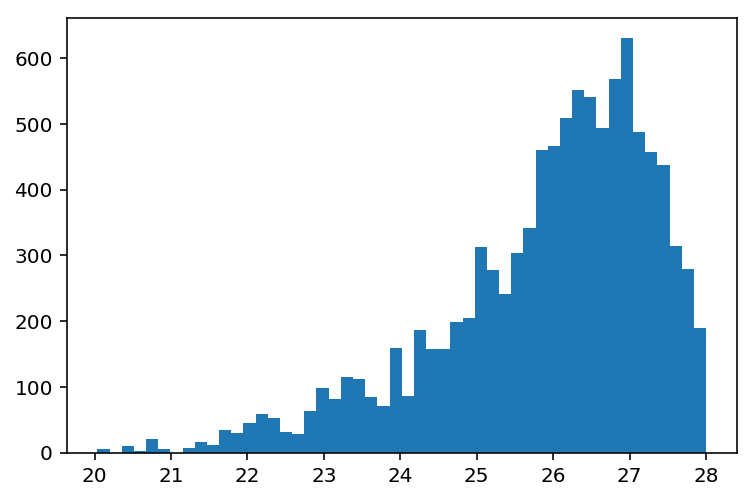

In [12]:
_ = plt.hist(df['mag'], bins = 50)
np.max(df['mag'])

# Parameters

In [13]:
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

psf = galsim.Kolmogorov(fwhm=0.65)
pix_scale_lsst = 0.2

batch_size = 100

n_years = 5

# LSST only

## Shape reproduction

In [14]:
df_lsst = results_processing.processing(deblender_lsst,
                                             data_dir,                                           
                                             root,
                                             test_sample[0],
                                             bands_lsst,
                                             2,
                                             stamp_size, 
                                             batch_size,
                                             psf,
                                             pix_scale_lsst,
                                              n_years)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99

(10000, 2, 2)


In [15]:
df_lsst.to_csv('data/df_deb_centered_lsst.csv')

In [16]:
df_lsst = pd.read_csv('data/df_deb_centered_lsst.csv', encoding = 'utf-8')

Plots

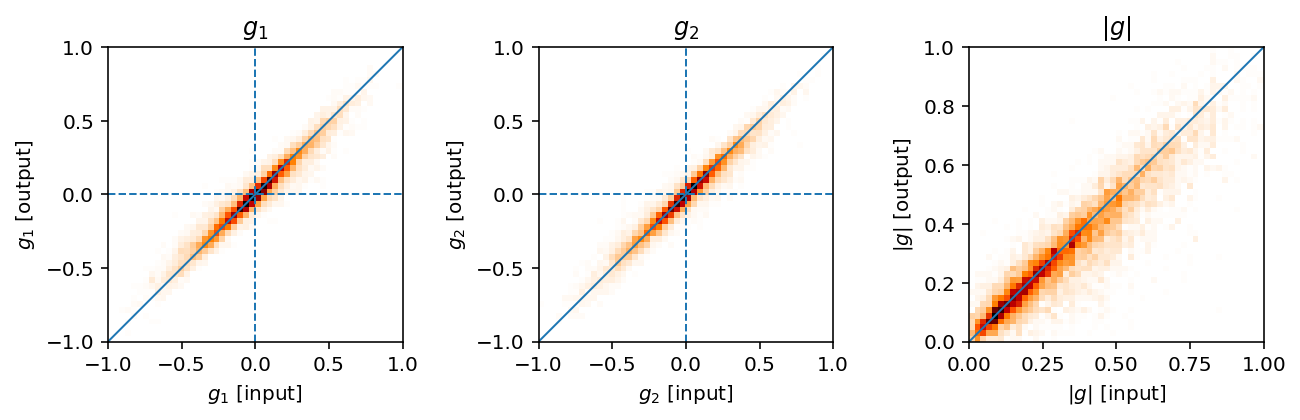

In [17]:
fig = plt.figure(figsize=(12,5))

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst['e1_in'], df_lsst['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst['e2_in'], df_lsst['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst['e_in'], df_lsst['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

plt.tight_layout()


## Flux reproduction

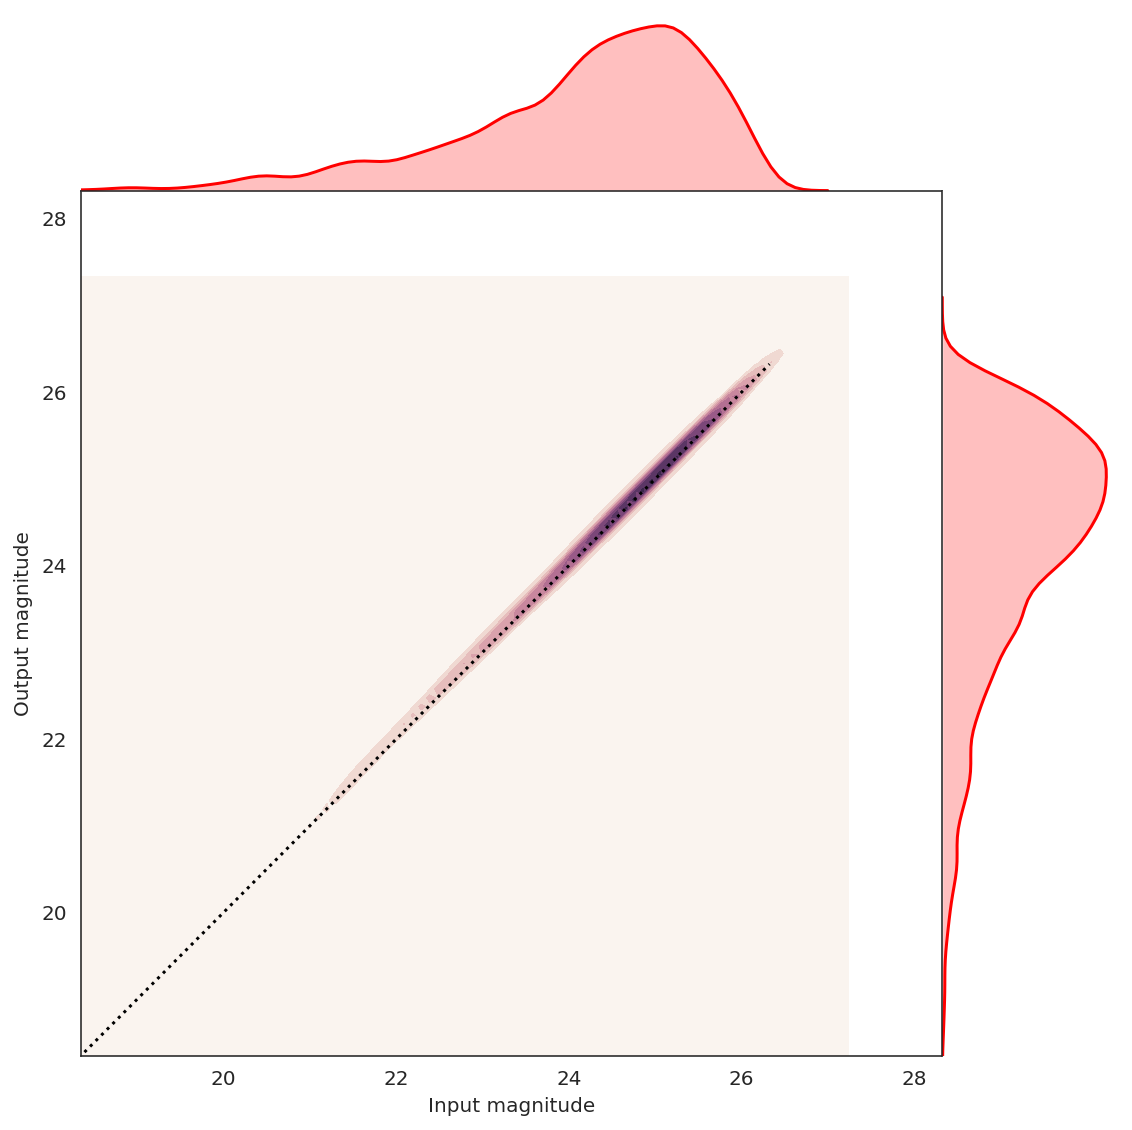

In [18]:
import matplotlib

#font = {'family' : 'normal',
#        'weight' : 'normal',
#        'size'   : 18}

#matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(df_lsst['mag_in'], df_lsst['mag_out'], kind='kde',height =8,
                              xlim =[np.min(df_lsst['mag_in']), np.max(df_lsst['mag_in'])+2], ylim=[np.min(df_lsst['mag_in']), np.max(df_lsst['mag_in'])+2],cmap=cmap,color = 'red', space=0).set_axis_labels('Input magnitude', 'Output magnitude')
            g.ax_joint.plot(np.linspace(-1, np.max(df_lsst['mag_in'])),
                            np.linspace(-1, np.max(df_lsst['mag_in'])), ':k')

# LSST + Euclid

## Shape reproduction

In [ ]:
df_lsst_euclid = results_processing.processing(deblender_lsst_euclid,
                                             data_dir,                                           
                                             root,
                                              test_sample[0],
                                              bands_lsst_euclid,
                                              6,
                                              stamp_size,
                                              batch_size,
                                              psf,
                                              pix_scale_lsst,
                                              n_years)

0
1
2
error for galaxy 858
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
error for galaxy 10456
27
28
29
30
31
32
error for galaxy 12839
33
34
35
36
37
38
39
40
41
42
43
44
error for galaxy 17632
45
46


In [ ]:
df_lsst_euclid.to_csv('data/df_deb_centered_lsst_euclid.csv')

In [ ]:
df_lsst_euclid = pd.read_csv('data/df_deb_centered_lsst_euclid.csv', encoding = 'utf-8')

In [ ]:
fig = plt.figure(figsize=(12,5))



emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e2_in'], df_lsst_euclid['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e_in'], df_lsst_euclid['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

plt.tight_layout()

## Flux reproduction

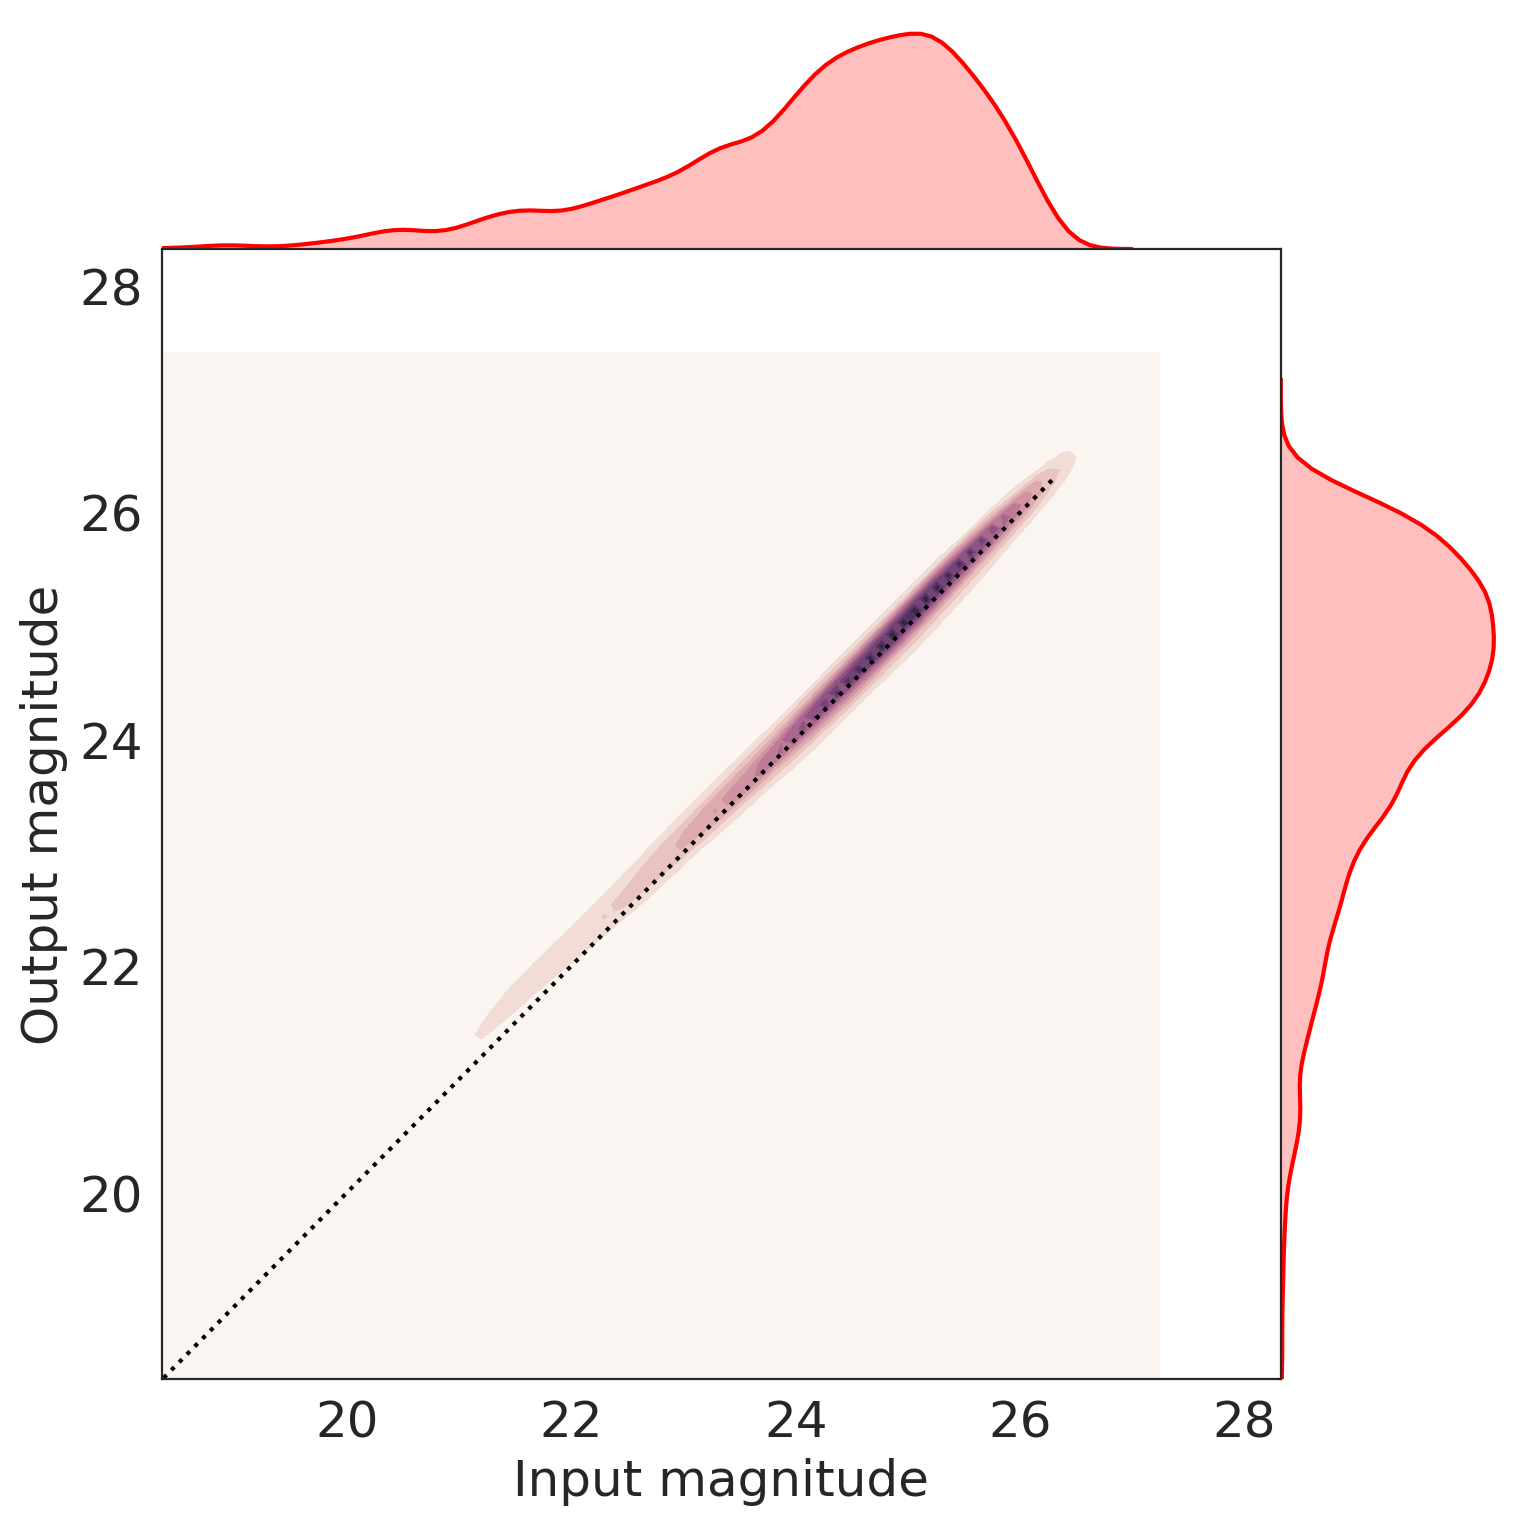

In [33]:
import matplotlib

#font = {'family' : 'normal',
#        'weight' : 'normal',
#        'size'   : 18}

#matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(df_lsst_euclid['mag_in'], df_lsst_euclid['mag_out'], kind='kde',height =8,
                              xlim =[np.min(df_lsst_euclid['mag_in']), np.max(df_lsst_euclid['mag_in'])+2], ylim=[np.min(df_lsst_euclid['mag_in']), np.max(df_lsst_euclid['mag_in'])+2],cmap=cmap,color = 'red', space=0).set_axis_labels('Input magnitude', 'Output magnitude')
            g.ax_joint.plot(np.linspace(-1, np.max(df_lsst_euclid['mag_in'])),
                            np.linspace(-1, np.max(df_lsst_euclid['mag_in'])), ':k')

# Delta WL parameters

## As function of SNR

In [34]:
df_plot = pd.concat([df_lsst, df_lsst_euclid], ignore_index=True)
df_plot['exp'] = [1]*10000 + [2]*10000

In [35]:
df_plot = df_plot.dropna(axis = 1, how = 'all')

### Error on ellipticity

In [36]:
np.min(df_plot['SNR'])

11.436230720070036

14848
[1 2]
0 1
1 2


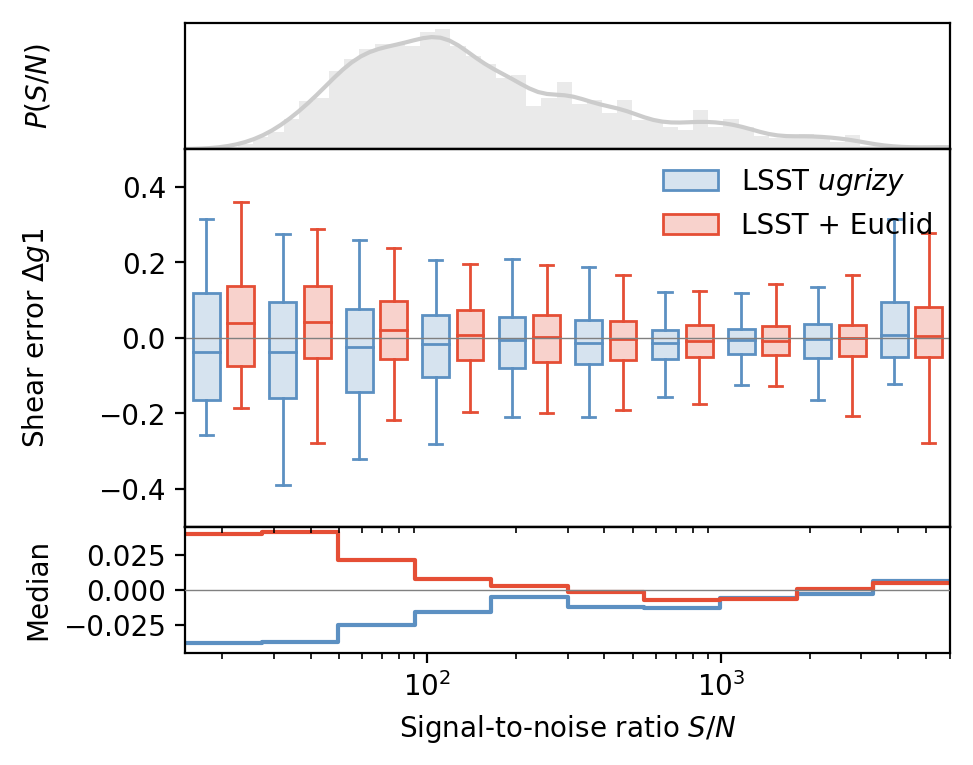

In [45]:
fig = boxplot_func(df_plot, x = 'SNR', y = 'e1_error', z = 'exp',
              xlim = (15, 6000),
              ylim = (-0.5, 0.5), 
              ylim2= (-0.045, 0.045),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Shear error $\\Delta g1$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'Median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

14848
[1 2]
0 1
1 2


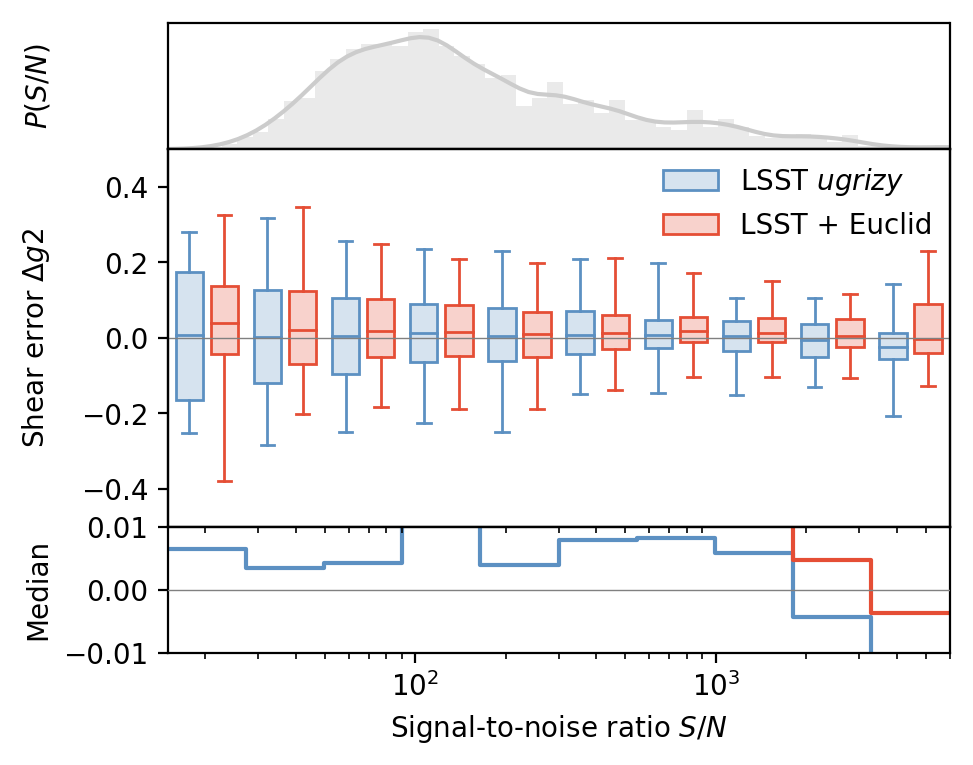

In [46]:
fig = boxplot_func(df_plot, x = 'SNR', y = 'e2_error', z = 'exp',
              xlim = (15, 6000),
              ylim = (-0.5, 0.5),
              ylim2= (-0.01, 0.01),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Shear error $\\Delta g2$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'Median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

14848
[1 2]
0 1
1 2


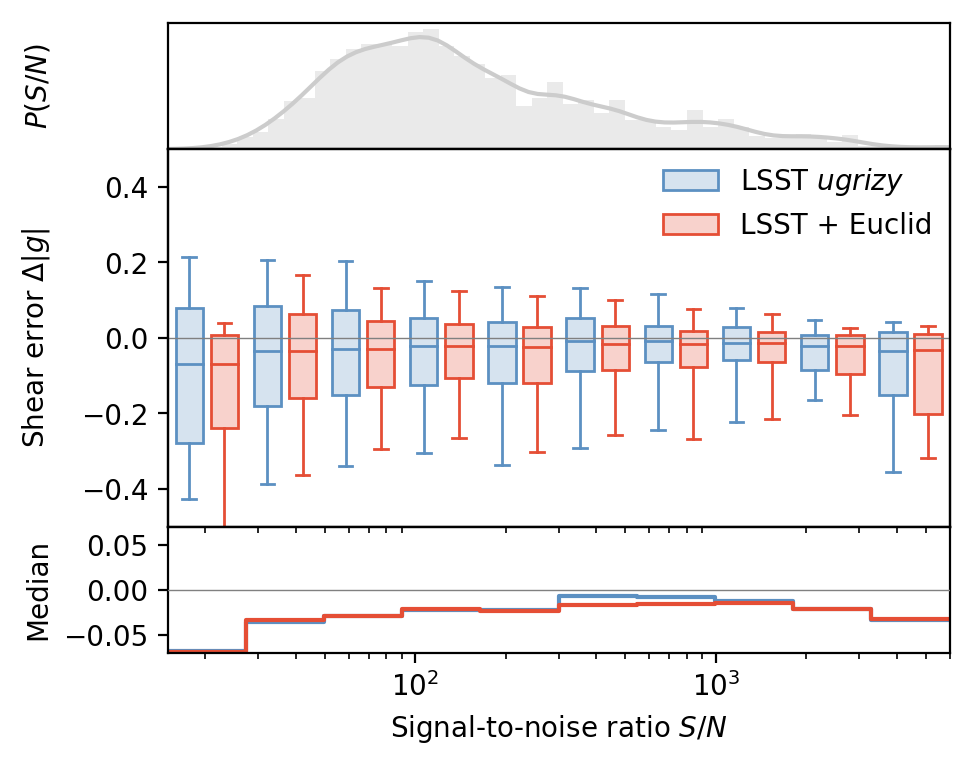

In [44]:
fig = boxplot_func(df_plot, x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (15, 6000),
              ylim = (-0.5, 0.5),
              ylim2= (-0.07, 0.07),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'Median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

#fig[0].savefig('figures/e_snr_2.pdf')

Magnitude error as function of S/N

14848
[1 2]
0 1
1 2


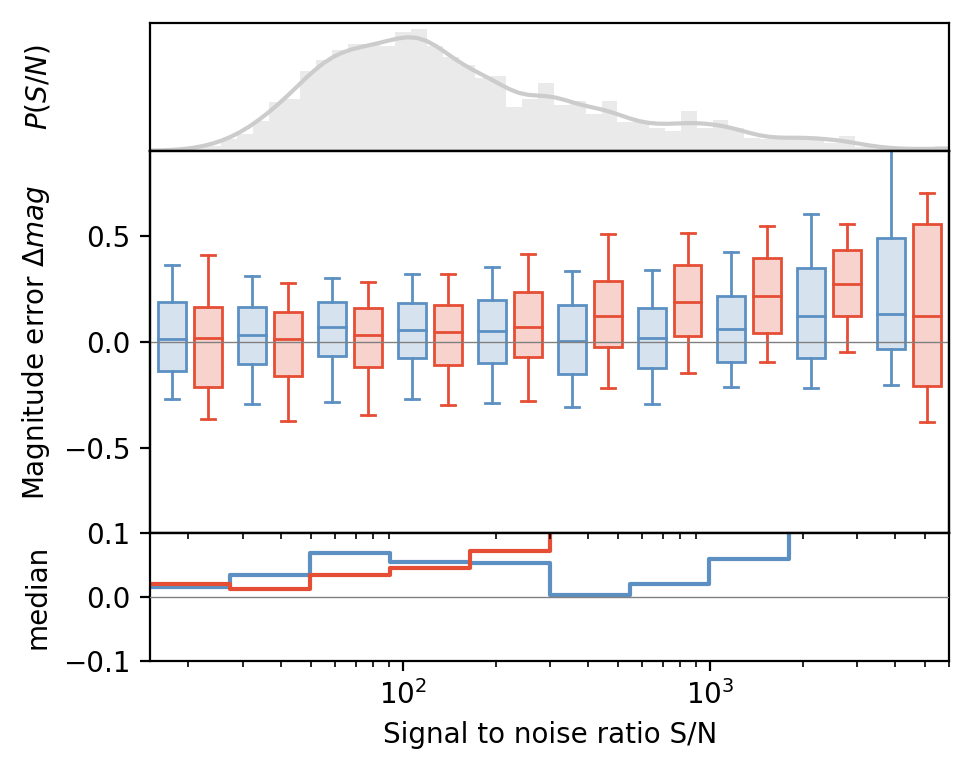

In [48]:
fig = boxplot_func(df_plot, x = 'SNR', y = 'delta_mag', z = 'exp',
              xlim = (15, 6000),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

#fig[0].savefig('figures/mag_snr_2.pdf')

### Error on flux

In [54]:
np.max(df_plot['mag'])

27.99953275237923

14848
[1 2]
0 1
1 2


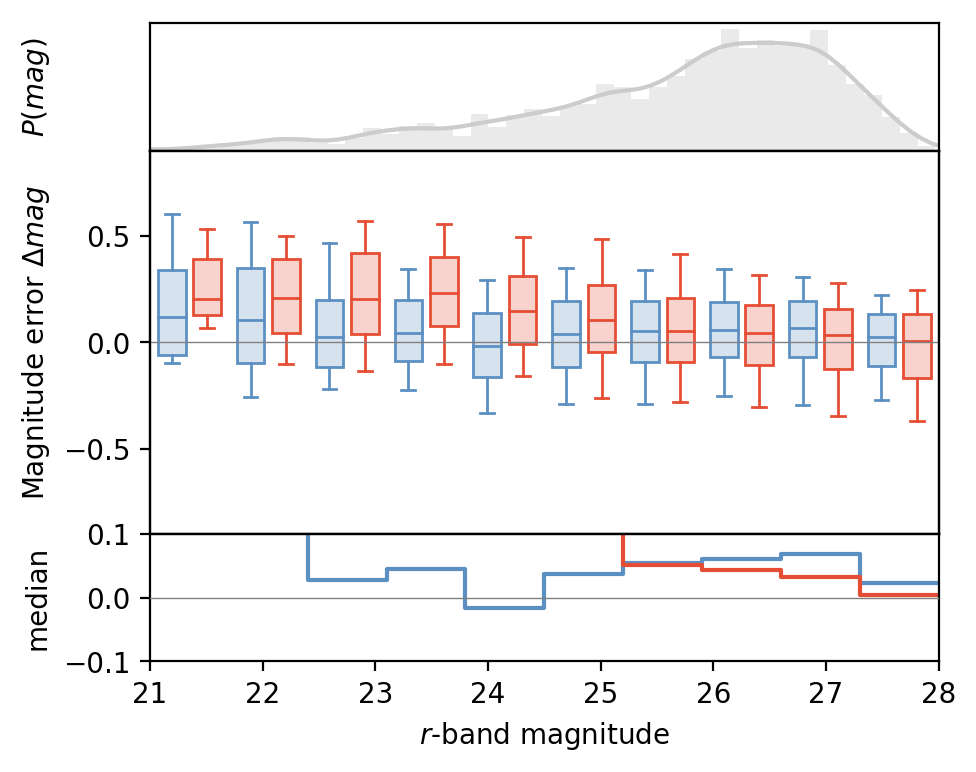

In [49]:
fig = boxplot_func(df_plot, x = 'mag', y = 'delta_mag', z = 'exp',
              xlim = (21., 28.),
              ylim = (-0.9,0.9), 
              ylim2 = (-0.1,0.1), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='$r$-band magnitude', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

#fig[0].savefig('figures/mag_mag_2.pdf')

## As a function of blend rate

### As a function of blend rate with closest

#### Error on ellipticity

14848
[1 2]
0 1
1 2


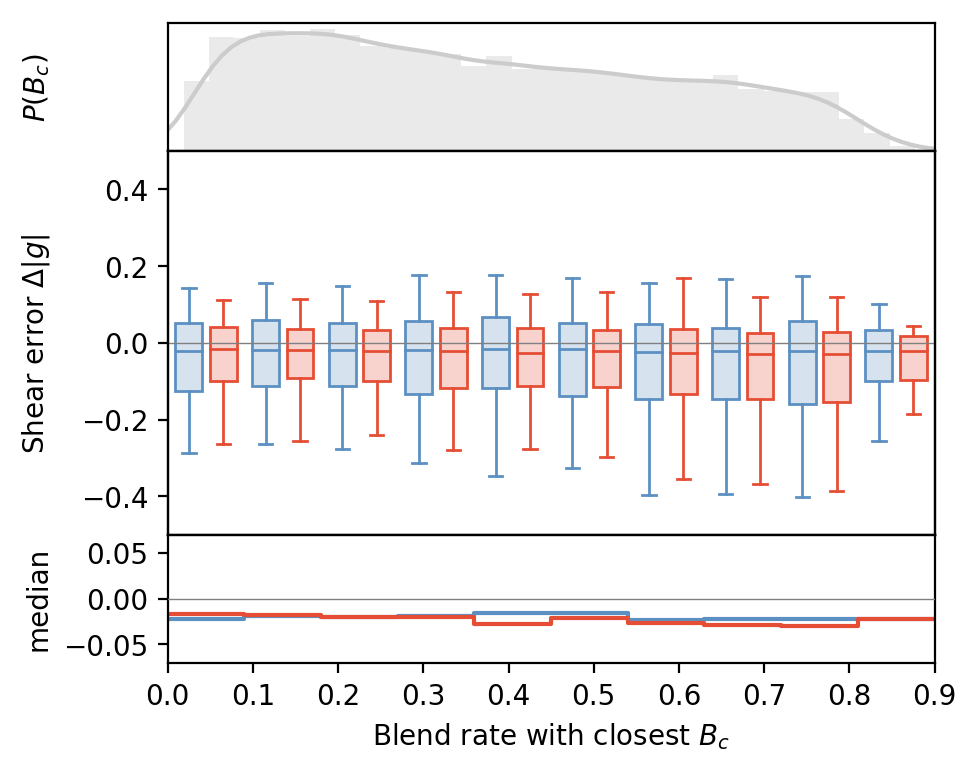

In [57]:
fig = boxplot_func(df_plot, x = 'blendedness_closest_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.9),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blend rate with closest $B_c$', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

#fig[0].savefig('figures/e_b_c_2.pdf')

#### Error on flux

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


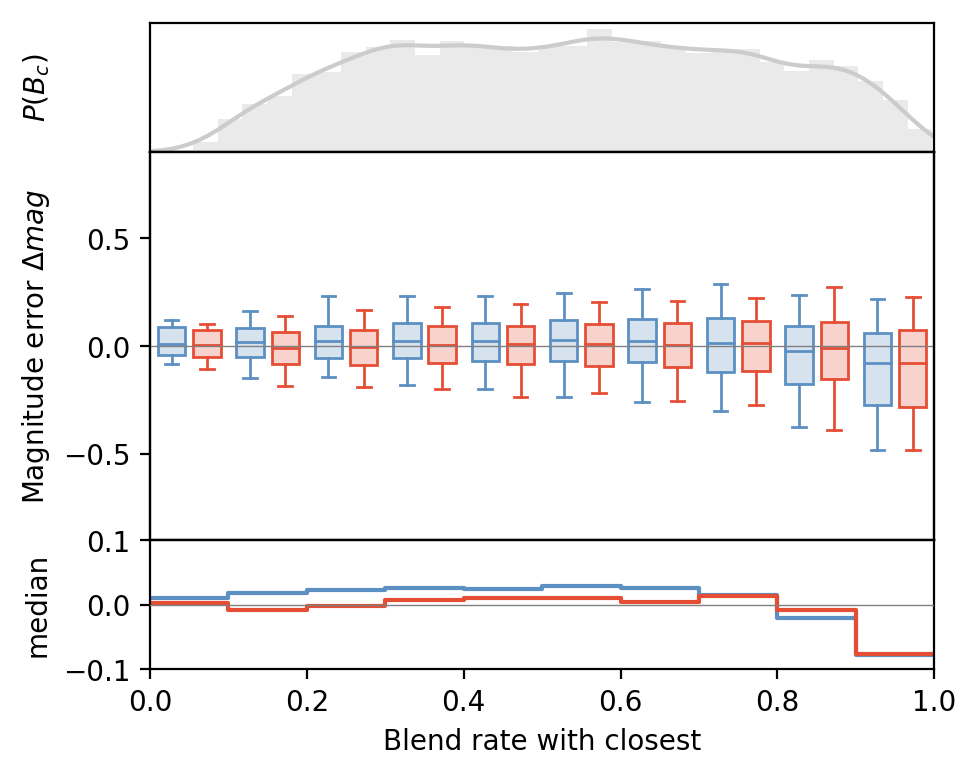

In [99]:
fig = boxplot(df_plot, x = 'blendedness_closest_lsst', y = 'mag_error', z = 'exp',
              xlim = (0., 1.),
              ylim = (-0.9,0.9), 
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blend rate with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_b_c_2.pdf')

### As a function of total blend rate

#### Error on ellipticity

In [53]:
np.max(df['blendedness_total_lsst'])

0.764361172914505

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


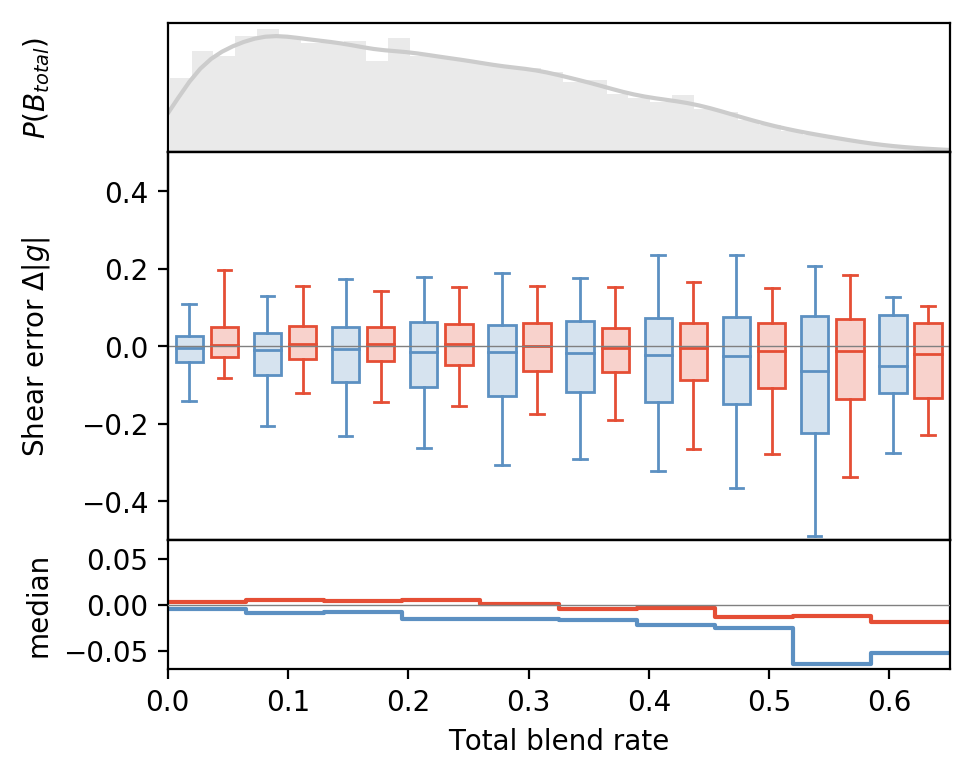

In [100]:
fig = boxplot(df_plot, x = 'blendedness_total_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.65),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Total blend rate', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(B_{total})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_b_tot_2.pdf')

#### Error on flux

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


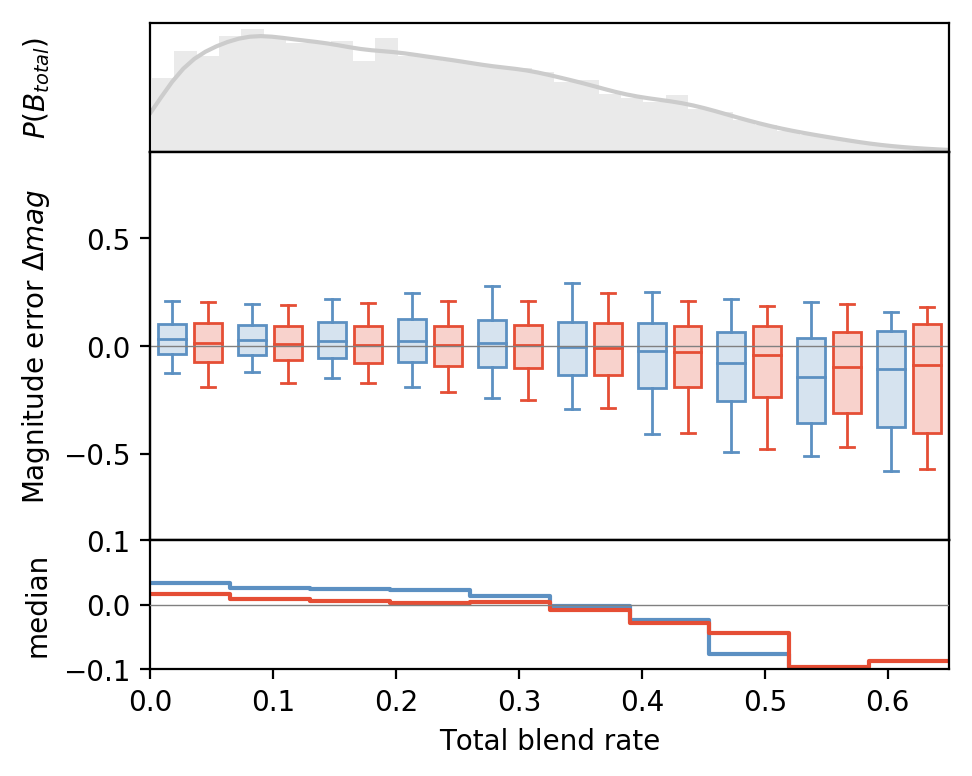

In [101]:
fig = boxplot(df_plot, x = 'blendedness_total_lsst', y = 'mag_error', z = 'exp',
              xlim = (0., .65),
              ylim = (-0.9,0.9), 
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Total blend rate', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_{total})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_b_tot_2.pdf')

## As a function of aperture blending fraction

### Error on ellipticity

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


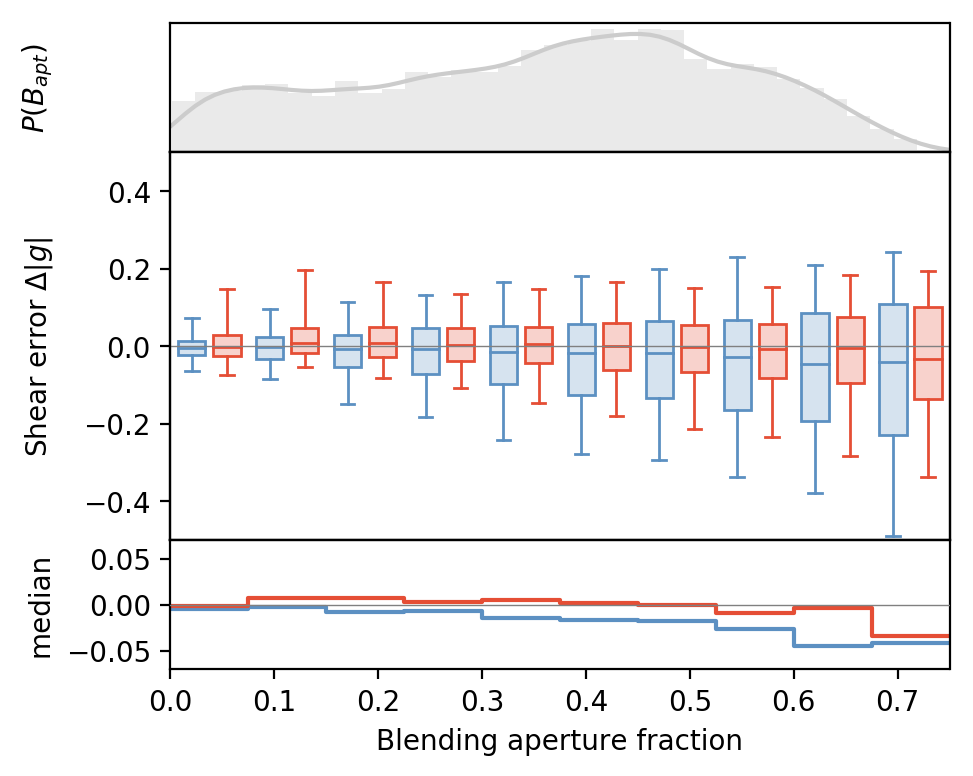

In [102]:
fig = boxplot(df_plot, x = 'blendedness_aperture_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.75),
              ylim = (-0.5,0.5),
              ylim2 = (-0.07,0.07),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blending aperture fraction', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(B_{apt})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_b_apt_2.pdf')

### Error on magnitude

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


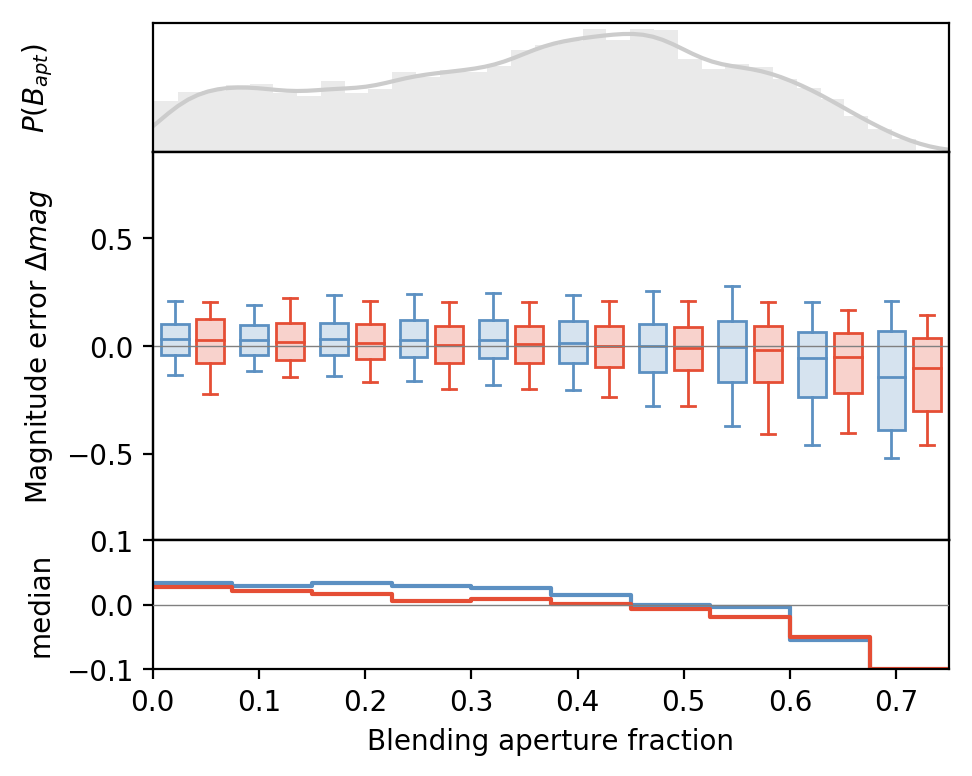

In [103]:
fig = boxplot(df_plot, x = 'blendedness_aperture_lsst', y = 'mag_error', z = 'exp',
              xlim = (0., .75),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blending aperture fraction', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_{apt})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_b_apt_2.pdf')

## As a function of delta magnitude

### Error on ellipticity

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


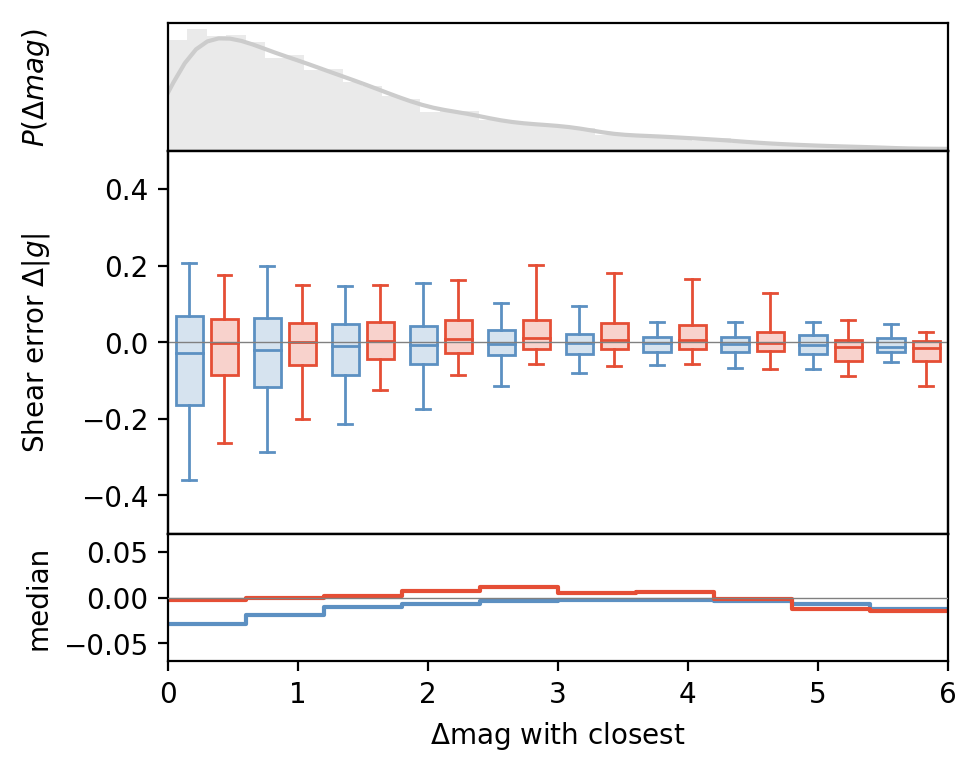

In [104]:
fig = boxplot(df_plot, x = 'delta_mag_closest', y = 'e_error', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_mag_c_2.pdf')

### Error on flux

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


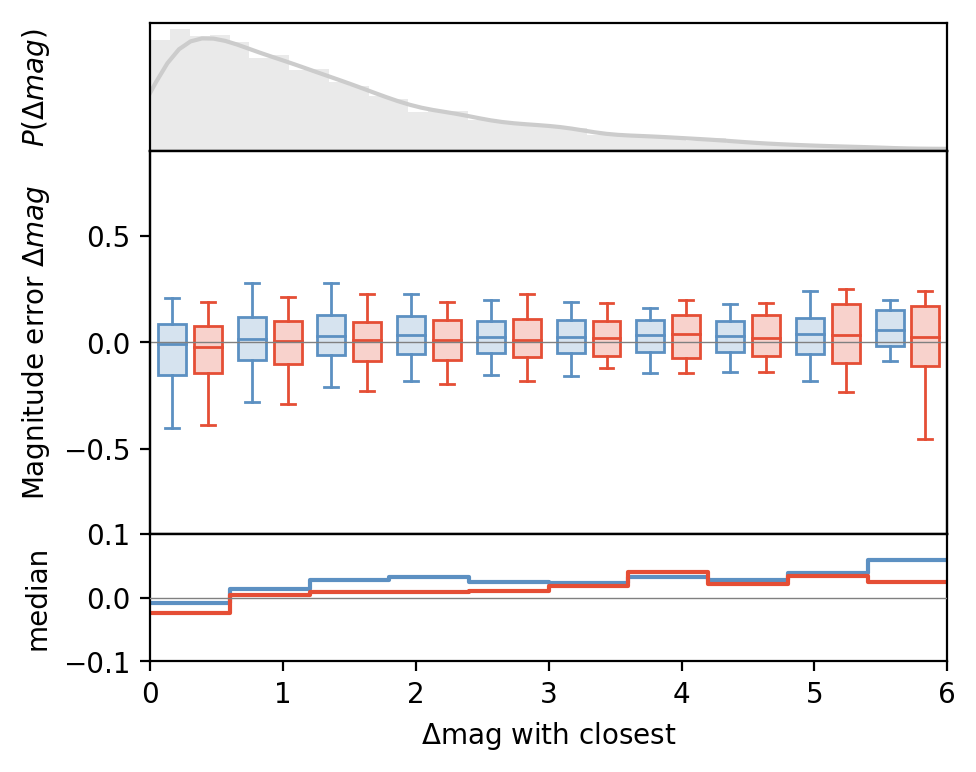

In [105]:
fig = boxplot(df_plot, x = 'delta_mag_closest', y = 'mag_error', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_mag_c_2.pdf')

# N sampling for the same galaxy on few blended images

In [112]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [113]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

In [114]:
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

In [115]:
list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)

NameError: name 'batch_gen_lsst_euclid' is not defined

In [ ]:
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

flux_out_lsst = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst_euclid = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
input_noiseless = []
input_noisy = []
output_deblender = []
output_deblender_lsst_euclid = []
blend_rate = []
nb_of_gal = []
err_count = 0

# Measurement of fluxes
mask = plot.createCircularMask(stamp_size,stamp_size,None,5)


for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    input_noiseless.append(denorm(list_galsim_simple[1], bands_lsst_euclid, channel_last = True))
    
    plt.imshow(list_galsim_simple[0][0][:,:,2])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    #try: 
    print(i)
    for j in range (nb_of_samplings):
        print(j)
        output_vae_list_lsst = deblender_lsst.predict(list_galsim_simple[0][:,:,:,4:], batch_size = batch_size)
        output_vae_list_lsst = denorm (output_vae_list_lsst, bands_lsst, channel_last = True)
        
        output_vae_list_lsst_euclid = deblender_lsst_euclid.predict(list_galsim_simple[0][:,:,:], batch_size = batch_size)
        output_vae_list_lsst_euclid = denorm (output_vae_list_lsst_euclid, bands_lsst_euclid, channel_last = True)
        
        if j == (nb_of_samplings-1) :  
            input_noisy.append(denorm(list_galsim_simple[0], bands_lsst_euclid, channel_last = True))
            output_deblender.append(output_vae_list_lsst)
            output_deblender_lsst_euclid.append(output_vae_list_lsst_euclid)
            blend_rate.append(list_galsim_simple[7][0])
            nb_of_gal.append(len(list_galsim_simple[5]))

        for t in range (batch_size):
            img_out_simple = galsim.Image(output_vae_list_lsst[t][:,:,2])
            res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
            res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
            res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst[t,:,:,2].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst[i,j*batch_size+t] = np.sum(masked_img_in_simple)

            img_out_simple_euclid = galsim.Image(output_vae_list_lsst_euclid[t][:,:,6])
            res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e1
            res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e2
            res_out_lsst_euclid_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst_euclid[t,:,:,6].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst_euclid[i,j*batch_size+t] = np.sum(masked_img_in_simple)

    #except :
    #    err_count +=1
    #    print('erreur')
    #    pass
    #continue
            
print(err_count)

In [34]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')
flux_in = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(input_noiseless[k][0][:,:,6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    masked_img_in_simple = input_noiseless[k][0][:,:,6].copy()
    masked_img_in_simple[~mask] = 0  
    flux_in[k] = np.sum(masked_img_in_simple)

    print(res_in_e1[k], res_in_e2[k])

0.0015546844 0.0059353914
0.24678348 0.26398543
-0.22094715 0.34989557


[]

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


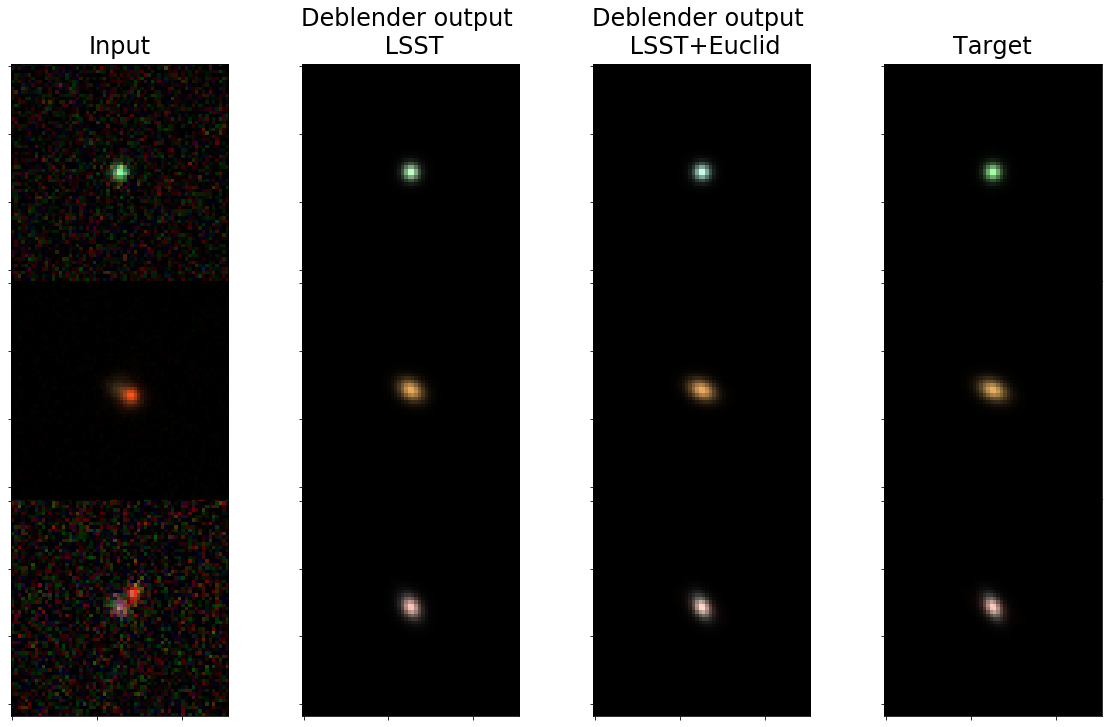

In [35]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.subplots_adjust(hspace=0)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))



####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Input', pad = 10)

ax = axes[0,1]
plot_rgb_lsst(np.mean(output_deblender[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST', pad = 10)

ax = axes[0,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST+Euclid', pad = 10)

ax = axes[0,3]
plot_rgb_lsst_euclid(input_noiseless[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Target', pad = 10)


####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
plot_rgb_lsst(np.mean(output_deblender[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,3]
plot_rgb_lsst_euclid(input_noiseless[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
plot_rgb_lsst(np.mean(output_deblender[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,3]
plot_rgb_lsst_euclid(input_noiseless[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

In [36]:
blend_rate

[array([], dtype=float64),
 array([0.53614187, 0.27017361, 0.28062558]),
 array([0.10091618])]

0.16652507 0.3


Text(0.5, 0, 'total flux in - total flux out / \n total flux in')

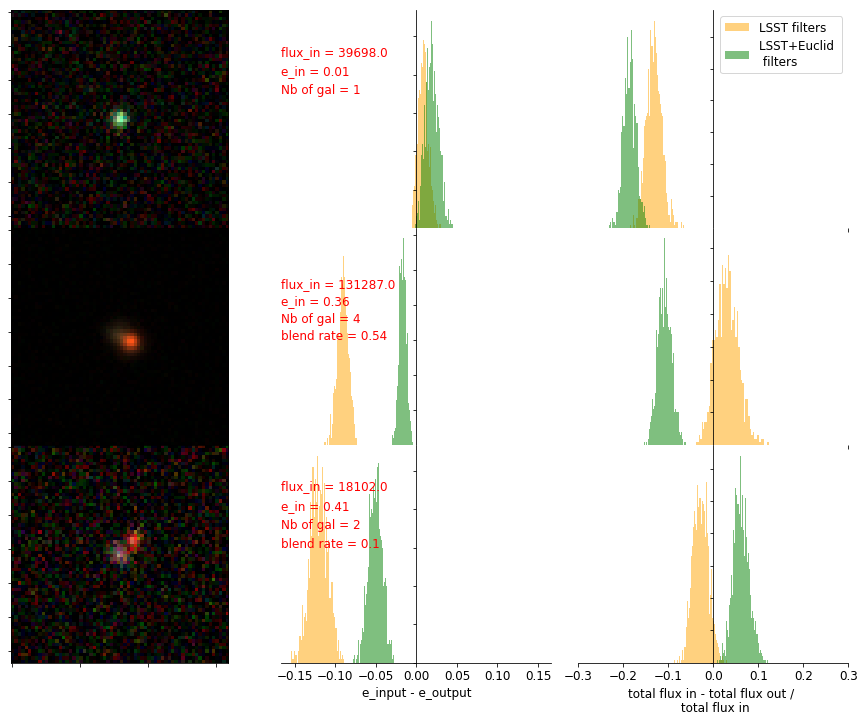

In [37]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))

max_x = np.max(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
min_x = np.min(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
max_lim_flux = 0.3# np.max((np.abs(max_x), np.abs(min_x)))

print(max_lim, max_lim_flux)
####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('Input', pad = 10)

ax = axes[0,1]
ax.hist(res_out_lsst_e[0]- res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[0]- res_in_e[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[0])+1, 0)), fontsize =12, color='r')
if len(blend_rate[0])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[0]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)

ax = axes[0,2]
ax.hist((flux_out_lsst[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.legend()
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)



####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
ax.hist(res_out_lsst_e[1]- res_in_e[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[1]- res_in_e[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color ='green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[1])+1, 0)), fontsize =12, color='r')
if len(blend_rate[1])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[1]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
ax.hist((flux_out_lsst[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
ax.hist(res_out_lsst_e[2]-res_in_e[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[2]- res_in_e[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[2])+1, 0)), fontsize =12, color='r')
if len(blend_rate[2])!=0:
       ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[2]), 2)), fontsize =12, color='r')

ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('e_input - e_output')


ax = axes[2,2]
ax.hist((flux_out_lsst[2]-flux_in[2])/flux_in[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('total flux in - total flux out / \n total flux in')
